# AMPLE-Py Learning Resource
This Jupyter notebook is a learning resource for understanding the mechanics and processes of the Material Point Method (MPM). The code, algorithms and explanations implemented in AMPLE-Py have been adapted from code written by Coombs and Augarde in the MATLAB-based Material Point Learning Environment (AMPLE) program:

*Coombs, W.M. and Augarde, C.E. (2020) 'AMPLE : A Material Point Learning Environment.', Advances in engineering software., 139. p.102748*

Further information on this can be found at [AMPLE](https://wmcoombs.github.io/).

This notebook will run the user through a simplified example problem based on a two-dimensional large deformation of an elastic cantilever beam with a point load at the free end.

# Background of the MPM
This details a very broad overview of the steps implemented in the material point method. The material point formulation with the relevant code is explained in more detail in the following sections of this notebook.
## Material Point Method Steps
1. Discretise the problem domain with material points (MPs) which act to carry information (mass, volume, stress, state variable)
2. Map the information back to a regular background finite element grid to carry out calculations
3. Map calculation results back to the MPs
4. Discard the mesh
5. Repeat the cycle

Mesh distortion can lead to the generation of inaccurate or completely incorrect results. By discarding  the mesh after each cycle it mitigates the issue of mesh distortion for large deformation problems. 

## Computational procedure
The steps in the implemented algorithm are concisely summarised below. The applied body force and/or point forces are split into a number of load steps and for each of these steps the following process is adopted:

1. Calculate the stiffness contribution, $\left [ K_p \right ]$, of all of the material points and assemble the individual contribution of each material point into the global stiffness matrix, $\left [ K \right ]$.
2. Calculate the internal force contribution, $\left \{ f^p \right \}$, of all of the material points using and assemble the contributions into the global internal force vector, $\left \{ f^R \right \}$.
3. Solve for the nodal displacements within a load step, using the N-R process until the out-of-balance force converges to a specified tolerance.
4. Update the material point positions, volumes and domain lengths through interpolation from the incremental nodal displacements, deformation gradient and stretch tensor.
5. Reset the background grid.

Displayed graphically, the implementation looks something like this:

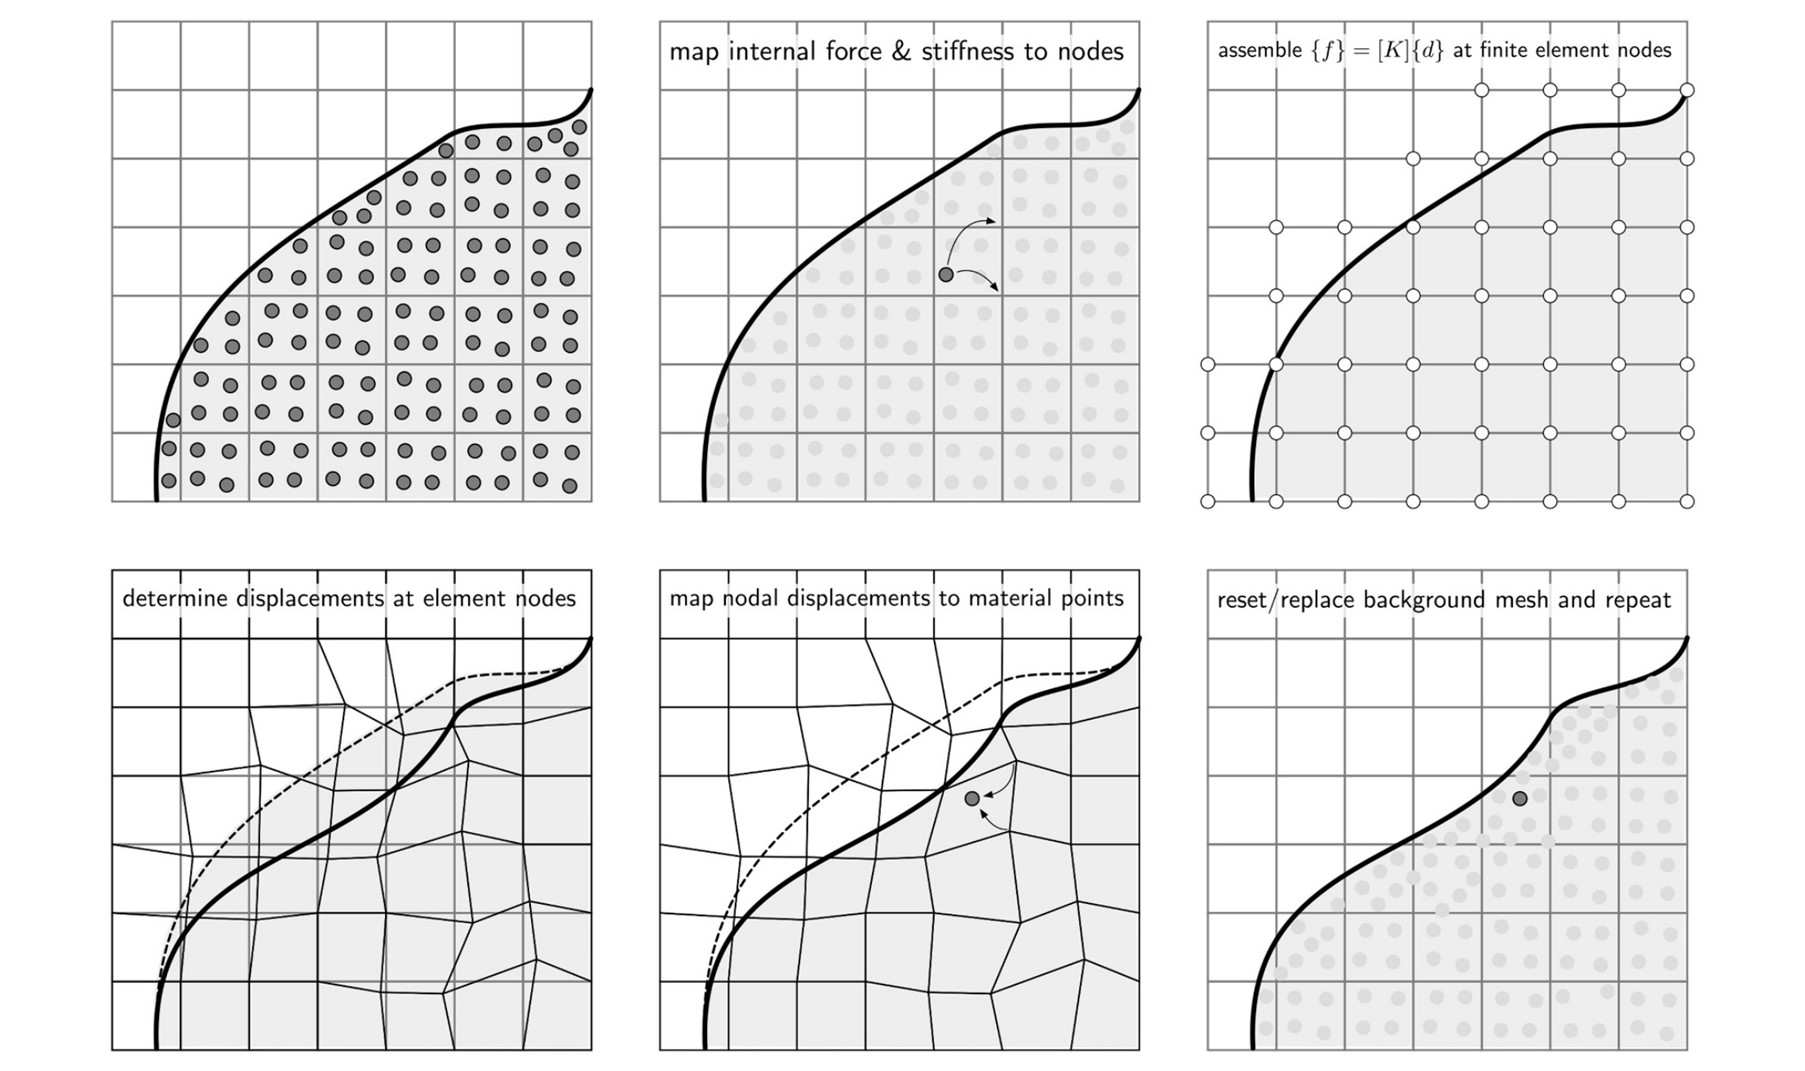

<h5><center>Figure 1: AMPLE-Py load step phases</center></h5>

# AMPLE-Py Code
## Importing necessary libraries to run AMPLE
To provide additional functionality, Python allows for packages to be imported to address specific needs. NumPy is the 'fundamental package for scientific computing in Python' - [NumPy](https://numpy.org/). This allows us to efficiently use  [n-Dimensional arrays](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) (nd arrays), which we can think of as being similar to matrices, for computations. We can also access efficient routines for operating on those arrays via NumPy. For sparse matrices, Python has a specific package for fast construction and manipulation that we also install: see [SciPy sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html).

In [18]:
import numpy as np
import numpy.linalg as npl
import numpy.matlib as npm
import scipy.sparse as sp

## Setup function
The following code is the start of the AMPLE program, calling a function that contains the setup information and variables defined outside of the load step loop. In this demonstration problem, a reduced number of material points, load steps and applied end load have been used to enable the user to more easily intuitively comprehend the method, without being distracted by an excessively large number of material points. Here, 160 material points are used, rather than in the original demonstration problem that used 1440.

The demonstration problem models the large deformation of an elastic cantilever beam with a point load at its free end using the material point method. The end load is split over the two material points closest to the free end either side of the neutral axis.

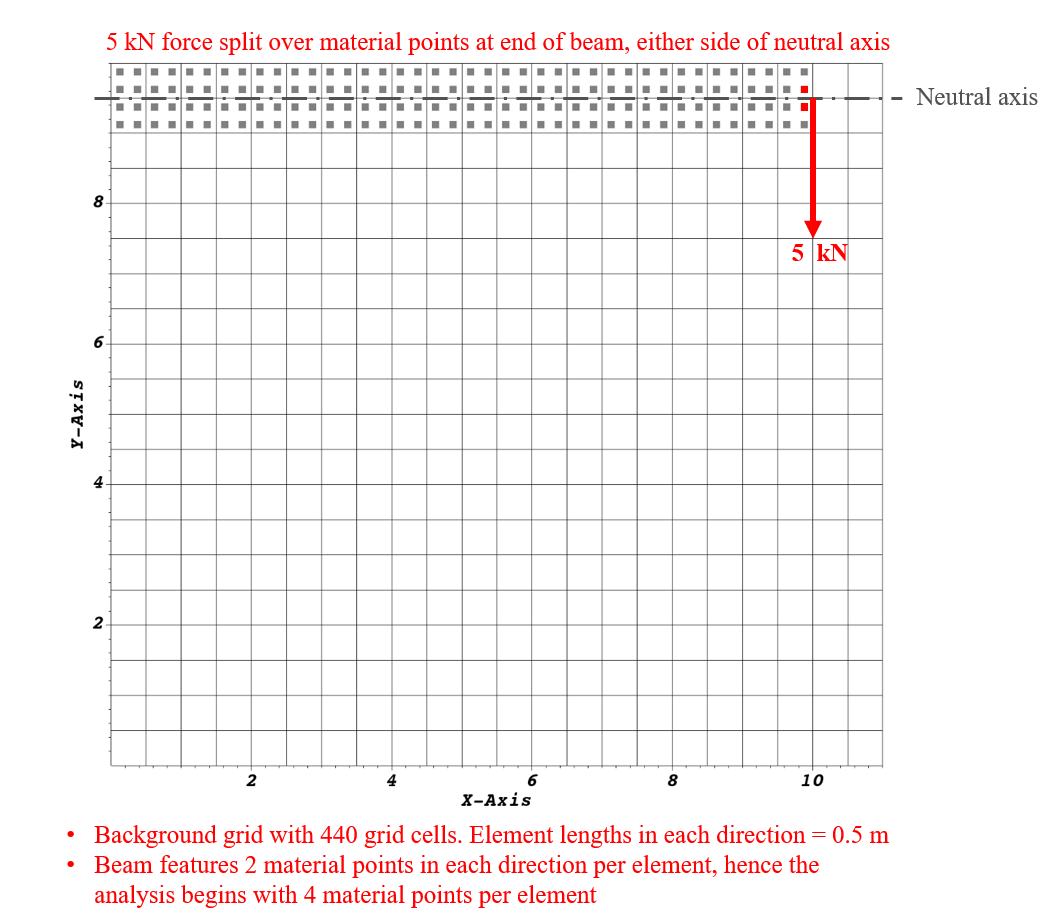

XXX Couldn't work out how to edit figure to make it smaller

<h5><center>Figure 2: Cantilever beam with grid discretisation and end load</center></h5> 

In [19]:
from setupGrid_beam_Jupyter import setupGrid_beam
lstps,g,mp_data,meshData = setupGrid_beam(np)

This function allows the user to modify the problem setup for the large deformation of an elastic beam. It returns:
- `lstps`    : the number of load steps the program will use
- `g`        : a gravity constant
- `mp_data`  : a list of material points (with material points given as objects)
- `meshData` : a meshData object with the following attributes: 
    - mesh nodal coordinates `coord`
    - element topology `etpl`
    - boundary conditions `bc`
    - background mesh size `h`
    - elements in analysis `eInA`

As this is an analysis of a problem featuring large deformation, the solution is non-linear by nature. This requires the solving of the nodal displacements to be done incrementally within a load step until they are within a given tolerance. 

In AMPLE-Py, each material point is an instance of the `mpDataPoint` class. This class defines the material points as objects with the following attributes:
* `mpType` : material point type (1 = MPM, 2 = GIMPM)
* `cmType` : constitutive model type (1 = elastic, 2 = vM plasticity)
* `mpC`    : material point coordinates
* `vp`     : material point volume
* `vp0`    : initial material point volume
* `mpM`    : material point mass
* `nIN`    : nodes linked to the material point
* `eIN`    : element associated with the material point
* `Svp`    : basis functions for the material point
* `dSvp`   : basis function derivatives (at start of lstp)
* `Fn`     : previous deformation gradient
* `F`      : deformation gradient
* `sig`    : Cauchy stress
* `epsEn`  : previous logarithmic elastic strain
* `epsE`   : logarithmic elastic strain
* `mCst`   : material constants (or internal state parameters)
* `fp`     : force at the material point
* `u`      : material point displacement
* `lp`     : material point domain lengths
* `lp0`    : initial material point domain lengths
    
Each material point is created and stored in the mp_data list. Attributes of an individual material point can be called as follows, with the domain length of the first material point used as an example: `mp_data[0].lp`. Try it below:

In [20]:
mp_data[0].mpM # you can change the material point you want to look at with mp_data[mp]. Attributes accessed by dot notation

array([0.])

**Note**: in this notebook, we will only consider an example problem using the standard material point type (MPM) with an elastic constitutive model type. Code using the alternative `mpType` and `cmType` options to implement the General Interpolated Material Point Method (GIMPM) and Von Mises plasticity can be run using the full the AMPLE-Py scripts. 

## Analysis parameters
From the mesh nodal coordinates we can determine the number of nodes in the background mesh and the number of dimensions used in the analysis. From the element topology, the number of elements in the background mesh and number of element nodes can be obtained. The number of degrees of freedom and number of material points can also be determined.

In [21]:
nodes, nD = meshData.coord.shape  # number nodes in background mesh, number of dimensions
nels,nen  = meshData.etpl.shape   # number of elements in background mesh, number of element nodes
nDoF = nodes*nD                   # number of degrees of freedom
nmp  = len(mp_data)               # number of material points
lstp = 0                          # initialise load step variable

## Entering load step loop
We use a `for` loop to increment the global external force vector over a set number of load steps.

### Determining basis functions and spatial derivatives of each material point (`elemMPinfo` function)
Basis functions are a key area of difference between the material point method and finite elements. In MPM, the local position of the material point can be linked to its position within its associated background grid cell. The basis functions can then be evaluation as in the finite element method. This can be expressed as the convolution of the material point's domain with the basis functions of the underlying finite element grid:

$$ S_{vp} = \frac{1}{V_{p}^{n}}\int_{\Omega_{p}}^{}\chi_{p}N_{\nu}(\tilde{X}_{p})dx \tag{1} $$ 

where $\Omega_{p}$ is the influence domain associated with the material point, $\chi_{p}$ is the material point’s characteristic function which defines the zone of influence (or domain) of a material point, $N_{\nu}$ are the underlying shape functions of the finite element grid which are dependent of the position of the material point at the start of the load step, $\tilde{X}_{p}$.

The following code determines the basis functions and spatial derivatives of each material point. 

The code also determines, and stores, the elements associated with the material point and a unique list of nodes that the material point influences.  The number of stiffness matrix entries for each material point is determined and stored. 

For this demonstration, we will only look at the first material point for simplicity. The code in full, goes through each individual material point in a `for` loop carrying out the same calculations for each one and updating them. The code can be run in full by calling the `elemMPinfo` function.

In [22]:
eInA = np.zeros([nels,1])                      # zero elements taking part in the analysis
# in elemMPinfo code, this would be the start of the for loop, but for demonstration 
# purposes, we will look at the first material point only (mp = 0)
mp = 0                                         # choose first element for demonstration problem

#### Find elements associated with the material point (`elemForMP` function)
Code determines the elements that are associated with a material point assuming that the material point's domain is symmetric about the particle position.

In [23]:
# elemForMP function parameters
coord = meshData.coord                          # element coordinates
etpl  = meshData.etpl                           # element toplogy
mpC   = mp_data[mp].mpC                         # material point coordinates
lp    = mp_data[mp].lp                          # domain half width lengths

In [24]:
# Finding particle domain lengths
Pmin  = (mpC-lp).flatten()                      # particle domain lengths (lower) as 1-D array
Pmax  = (mpC+lp).flatten()                      # particle domain lengths (upper)
a     = np.ones((nels, 1), dtype=bool)          # initialises boolean logical array of size (nels,1)

In [25]:
for i in range(0,nD):                    
    ci = coord[:,i]                             # nodal coordinates in current i direction
    c  = ci[etpl-1]                             # reshaped element coordinates in current i direction
    Cmin = (c.min(axis=1)).reshape(nels,1)      # element lower coordinate limit     
    Cmax = (c.max(axis=1)).reshape(nels,1)      # element upper coordinate limit
    # For a 2D array, X.min()       finds the single minimum value in the array
    #                 X.min(axis=0) returns the minimum value for each column 
    #                 X.min(axis=1) returns the minimum value for each row
    
    a = a * ((Cmin<Pmax[i]) * (Cmax>Pmin[i]))   # element overlap with mp domain

Here, `a` is a boolean array consisting of true/false values that are used below to determine a vector containing the elements associated with the material point - `eIN`. 

In [26]:
eIN = np.array([range(0,nels)]).reshape(nels,1) # list of all elements
eIN = eIN[a>0].astype(int)                      # remove those elements not in the domain

#### Unique list of nodes associated with a material point (`nodesForMP` function)
This code determines a unique list of nodes for a group of elements connected to a material point

In [27]:
elems = eIN                                     # elements in group
e1    = etpl[elems,:].flatten('F')              # list of all nodes (inc. duplicates)  
e     = np.sort(e1).tolist()                    # sorting list of nodes in ascending order
nodes_list = list(dict.fromkeys(e))             # unique list of nodes (removes duplicates)
nodes = np.asarray(nodes_list)                  # unique list of nodes (as array)

nIN   = nodes
nn    = len(nIN)                                # number of nodes influencing the MP

Use the cell below to have a look at values. Which nodes are unique to the first material point?

In [28]:
# Try typing values below and running this cell:
nIN

array([415, 416, 438, 439])

#### Basis functions for the material point method (`MPMbasis` function)
For each node, the basis function and spatial derivatives can be calculated. We will look at the first node from the list of nodes `nIN` for the first material point.

In [29]:
node   = nIN[0]                                 # first node
coord  = meshData.coord[node-1,:]               # node coordinates (-1 because of zero-indexing)
h      = meshData.h                             # grid spacing

S_mp    = np.zeros([nD,1])                      # zero vectors used in calculations for one material point
dS_mp   = np.zeros([nD,1]) 
dSvp_mp = np.zeros([nD,1])

In [30]:
# Which node are we looking at?
print(node)

415


#### Determine 1D material point basis functions (`SvpMPM` function)
Determining the one dimensional MPM shape functions based on global coordinates.
The basis functions are obtained by replacing the characteristic function, $\chi_{p}$, with a Dirac delta function. Equation (1) to determine $S_{vp}$ becomes:

$ S_{vp} = 1 + (\tilde{X}_{p} - \tilde{X}_{v})/h\;\quad -h < \tilde{X}_{p} - \tilde{X}_{v} \leq 0 \tag{2}$

$ S_{vp} = 1 - (\tilde{X}_{p} - \tilde{X}_{v})/h\;\qquad 0 < \tilde{X}_{p} - \tilde{X}_{v} \leq h \tag{3}$

where $h$ is the size of the background grid and $\tilde{X}_{v}$ is the position of the node associated with the basis function at the start of the load step. The gradients of the basis functions are:

$ \Delta_{\tilde{X}}S_{vp} = 1/h\;\quad -h < \tilde{X}_{p} - \tilde{X}_{v} \leq 0 \tag{4}$

$ \Delta_{\tilde{X}}S_{vp} = -1/h\;\quad  0 < \tilde{X}_{p} - \tilde{X}_{v} \leq h \tag{5}$

This is implemented in the code (looking at the first node for the first material point) as follows:

In [31]:
for i in range(0,nD):
    xp = mpC[i]; xv = coord[i]; hi = h[i]
    
    if -hi < (xp - xv) and (xp - xv) <= 0:       # MP in 'left' element
        Svp  = 1 + (xp-xv)/hi
        dSvp = 1/hi

    elif 0 < (xp - xv) and (xp - xv) <= hi:      # MP in 'right' element
        Svp  = 1 - (xp-xv)/hi
        dSvp = -1/hi

    else:                                        # MP outside of element
        Svp  = 0
        dSvp = 0
    
    S_mp[i] = Svp;    dS_mp[i] = dSvp            # 1D MPM functions
    
Svp = np.prod(S_mp)                              # basis function (1D)
# np.prod finds product of array elements

S   = Svp.copy()
# this variable used to update basis functions vector in this notebook

Where `xp` is the particle position, `xv` is the grid node position and `h` is the element length.


In [32]:
# Check values below:
S

0.5625

#### For multi-dimension problems:
The gradients of the basis functions are obtained from the product of the gradient in one direction with the shape function in the other direction. Eg. the derivative of the basis functions with respect to $\tilde{X}$ in a 2D problem is:

$$ \frac{\partial S_{vp}(\tilde{X},\tilde{Y})}{\partial \tilde{X}} = \nabla_{\tilde{X}}S_{vp}(\tilde{X}) \times S_{vp}(\tilde{Y}) \tag{6}$$

This is implemented in the code as follows:

In [33]:
if nD == 1:                                             # index for basis derivatives (1D)
    indx = np.array([])
elif nD == 2:                                           # index for basis derivatives (2D)
    indx = np.array([1,0]).reshape(2,1) 
elif nD == 3:                                           # index for basis derivatives (3D)
    indx = np.array([1,2,0,2,0,1]).reshape(3,2)

for i in range(0,nD):
    dSvp_mp[i] = dS_mp[i]*np.prod(S_mp[indx[i,:]])      # gradient of the basis function

dS = dSvp_mp   

In [34]:
# Check values below:
dS

array([[-1.5],
       [-1.5]])

In [35]:
Svp  = np.zeros([1,nn]).flatten('F')                    # zero basis functions
dSvp = np.zeros([nD,nn])                                # zero basis function derivatives

# Using values calculated above for the basis function of the first node (Svp[0])
Svp[0] = Svp[0] + S
dSvp[:,0] = dSvp[:,0].copy() + dS.flatten('F') 

In [36]:
# Run this cell to see the updated values for Svp and dSvp for the first node:
print(Svp)
print()                                                 # prints blank line
print(dSvp)

[0.5625 0.     0.     0.    ]

[[-1.5  0.   0.   0. ]
 [-1.5  0.   0.   0. ]]


For all nodes of a material point, the steps shown above are done in a `for` loop to cycle through all the nodes to calculate the remaining values. `Svp` and `dSvp` are calculated using the same methods as shown above in the function `MPMbasis`. We will re-zero the values we previously calculated so the loop can run through without being affected any previously saved results.

In [37]:
from MPMbasis import MPMbasis

Svp  = np.zeros([1,nn]).flatten('F')                        # zero basis functions
dSvp = np.zeros([nD,nn])  

for i in range(0,nn): 
    node = nIN[i]                                           # current node
    S,dS = MPMbasis(np,meshData,mp_data[mp],nD,node)        # basis function and spatial derivatives
    Svp[i]    = Svp[i].copy() + S                           # basis functions for all nodes
    dSvp[:,i] = dSvp[:,i].copy() + dS.flatten('F')          # basis function derivatives

Now you can see basis functions, $ S_{vp} $, and derivatives, $\nabla_{\tilde{X}}S_{vp} $, have been calculated for all the nodes of the first material point:

In [38]:
# Run this cell to see the updated values for Svp and dSvp for all the nodes for the first material point:
print(Svp)
print()
print(dSvp)

[0.5625 0.1875 0.1875 0.0625]

[[-1.5  1.5 -0.5  0.5]
 [-1.5 -0.5  1.5  0.5]]


Finally, the values calculated above are updated by assigning them to the relevant attributes of the material point. The element in the analysis associated with the material point is then updated in the next code cell and stored in an integer array, `eInA`. All the material points store their associated elements in this array, ready to be assigned to the object attribute we left empty in the `meshData` object earlier after all the material points have been looped through.

**Reminder:** we assigned `meshData` the following attributes:
- mesh nodal coordinates `coord`
- element topology `etpl`
- boundary conditions `bc`
- background mesh size `h`
- **elements in analysis `eInA`** (this array stores all of the elements in the analysis for all the material points)

In [39]:
mp_data[mp].nIN  = nIN                                       # nodes associated with material point
mp_data[mp].eIN  = eIN + 1                                   # elements associated with material point
# (need +1 in eIN because of Python's zero indexing)
mp_data[mp].Svp  = Svp                                       # basis functions
mp_data[mp].dSvp = dSvp                                      # basis function derivatives
mp_data[mp].nSMe = (nn*nD)**2                                # number stiffness matrix components
eInA[eIN] = 1                                                # identify elements in the analysis

In [40]:
# Have a look at the updated attributes. Change the dot notation to see different attributes:
mp_data[mp].nIN                                              # nIN used as example

array([397])

That was just for the first material point! The values for each material point are calculated in a `for` loop inside the `elemMPinfo` function. Instead of passing back individual material point objects to the main function, we pass it the `mp_data` list with all the updated material points. We have also found the elements associated with the material points in our analysis and stored them in an integer array. Let's run that in full by calling the `elemMP` function and move on to the next step.

In [41]:
from elemMPinfo  import elemMPinfo
meshData,mp_data = elemMPinfo(np,mp_data,meshData)

In [42]:
# You can have a look at the updated values for all the material points here. 
# Choose a material point and an attribute we have updated:
mp = 0
mp_data[mp].Svp

array([0.5625, 0.1875, 0.1875, 0.0625])

### Determining the external forces (`detExtForce` function)
External tractions are ignored in the following code as their implementation is complex within the MPM. Dirichlet boundary conditions are imposed directly on the background mesh, as in finite elements. The nodal body forces are approximated using:

$ \left \{f_b  \right \} = \left [ S_{vp} \right ]^{T}\left \{b  \right \}V_{p} = \left [ S_{vp} \right ]^{T}\left \{g  \right \}m_{p} \tag{7}$

where $\left \{b  \right \} = \rho \left \{ g \right \}$ is the body force associated with the material point.
For two dimensional analysis, $g = \left \{ g(0\quad -1) \right \}$ where $\rho$ is the material’s density, $g$ is gravitational acceleration and $m_{p} = \rho V_{p}$ is the mass associated with the material point. Point forces, if required, are held and convected with the material points. They are mapped to the background grid using:

$ \left \{f_P  \right \} = \left [ S_{vp} \right ]^{T}\left \{f_{p}  \right \} \tag{8}$

Where $\left \{f_p  \right \}$ is the point force associated with the material point and $\left \{f_P  \right \}$ are the equivalent nodal values. 

*Note: lowercase $p$ subscript is used for point force, whilst an uppercase $P$ subscript is used to denote the nodal values.*

Here, we are going to determine the external forces at the nodes based on body forces and point forces at each material point. This is also done in a `for` loop, cycling through each material point, but again we are going to look at the first material point.

In [43]:
nodes = meshData.coord.shape[0]                                # want total number of nodes in analysis
fext = np.zeros([nodes*nD,1])                                  # zero the external force vector
grav = np.zeros([nD,1])                                        # initialise gravity vector
grav[nD-1] = -g                                                # gravity vector

# This would be the start of our mp for loop, but we choose to look at the first element only
mp = 0                                                         # choose first material point

In [44]:
nIN = mp_data[mp].nIN                                          # nodes associated with MP
nn  = len(nIN)                                                 # number of nodes influencing the MP
Svp = mp_data[mp].Svp                                          # basis functions
fp  = (mp_data[mp].mpM*grav + mp_data[mp].fp)*Svp              # material point body & point nodal forces
fp  = fp.flatten('F').reshape(nn*nD,1,1)                       # reshape this so it is compatible with fext vector below

In [45]:
# Can look at values here:
fp.shape

(8, 1, 1)

In [46]:
ed1 = npm.repmat((nIN-1)*nD,nD,1)                              # repeats nIN row vector nD times (vertically)
ed2 = npm.repmat(np.arange(1,nD+1).reshape(nD,1),1,nn)         # repeats vector from 1 to nD, nD times (vertically)
ed  = ed1 + ed2                                                # nodal degrees of freedom
ed  = ed.flatten('F')                                          # flatten matrix so can use it as index in fext vector
ed  = ed.reshape(nn*nD,1) -1                                   # need -1 for zero indexing
fext[ed] = fext[ed].copy() + fp                                # make copy of fext so aliasing* does not occur

*aliasing: when we refer to variables as objects, if we assign one variable to another, both variables refer to the same object. This means changes made to the reassigned variable also make changes to the original variable. Making a copy of `fext` in the last line of the code above means there is no chance of this happening.

In [47]:
# fext will be a very long vector, but have a look at the other variables to make sure you know that the code is doing:
print(ed)    # choosing ed as an example

[[828]
 [829]
 [830]
 [831]
 [874]
 [875]
 [876]
 [877]]


Determining `fext` for every material point (rather than just the one we chose to look at) is done within a `for` loop, and is called in full using the function `detExtForce` as shown below:

In [48]:
from detExtForce import detExtForce 
fext = detExtForce(np,npm,nodes,nD,g,mp_data)

We want to apply the external force over a number of load steps (these are set in the `setupGrid` function at the beginning of the program). 

In [49]:
fext = fext*lstp/lstps                                      # current external force value                             
oobf = fext                                                 # initial out-of-balance force
fErr = 1                                                    # initial error
frct = np.zeros([nDoF,1])                                   # zero reaction forces
uvw  = np.zeros([nDoF,1])                                   # zero nodal displacements

#### Determine the free degrees of freedom on the background mesh  (`detFDoFs` function)
Here, we will determine the free degrees of freedom of the background mesh based on the elements that contain material points and the displacement boundary conditions.

In [50]:
incN    = np.unique(meshData.etpl[meshData.eInA[:,0]>0,:])   # unique active node list
iN      = incN.shape[0]                                      # number of nodes in the list
incDoF1 = npm.repmat(incN*nD,nD,1)                           # create 'row vector' (incN) that is copied nD times
incDoF2 = np.arange(nD-1,-1,-1).reshape(nD,1)                # creates nDx1 column vector
incDoF2 = npm.repmat(incDoF2,1,iN)                           # turn column vector into row vector (iN long)
incDoF  = (incDoF1 - incDoF2).flatten(order = 'F')           # active degrees of freedom
fd      = np.arange(1,nDoF +1)                               # all degrees of freedom (need +1 because of zero indexing)
fd[meshData.bc[:,0]-1] = 0                                   # zero fixed displacement BCs
fd      = fd[incDoF-1]                                       # only include active DoF 
fd      = fd[fd>0]                                           # remove fixed displacement BCs

In [51]:
# What are the active degrees of freedom?
print(incDoF)
print()

# Which are the fixed displacement boundary conditions (without zero-indexing)?
print(meshData.bc[:,0])

[829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846
 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864
 865 866 867 868 869 870 875 876 877 878 879 880 881 882 883 884 885 886
 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904
 905 906 907 908 909 910 911 912 913 914 915 916 921 922 923 924 925 926
 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944
 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962]

[  1  47  93 139 185 231 277 323 369 415 461 507 553 599 645 691 737 783
 829 875 876 921]


In [52]:
# Any other values/variables you'd like to check? Just print them below:
print(fd)

[830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847
 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865
 866 867 868 869 870 877 878 879 880 881 882 883 884 885 886 887 888 889
 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907
 908 909 910 911 912 913 914 915 916 922 923 924 925 926 927 928 929 930
 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948
 949 950 951 952 953 954 955 956 957 958 959 960 961 962]


In [53]:
# Zeroing  values before entering Newton-Raphson while loop

NRit = 0                                                    # zero Newton-Raphson iteration counter
Kt   = 0                                                    # zero global stiffness matrix

## Enter Newton-Raphson `while` loop
This part of the code aims to achieve convergence between the externally applied loads and the internal forces at the nodes. Once equilibrium is obtained, the material point positions and internal variables (deformation gradient, stress, elastic logarithmic strain, domain size, etc.) are updated. First, we need to solve the linear system of equations to increment the displacements and the reaction forces. 

### Linear solver (`linSolve` function)
The linear system is only solved for the first Newton-Raphson iteration (`NRit > 0`) onwards as the zeroth iteration is required to construct the stiffness matrix based on the positions of the material points at the start of the loadstep. This is different from the finite element method where the stiffness matrix from the last iteration from the previous loadstep can be used for the zeroth iteration. The positions of the material points are obtained in the `detMPs` function we sill go on to look at.

In the case of non-zero displacement boundary conditions, these are applied when `NRit = 1` and then the displacements for these degrees of freedom are fixed for the remaining iterations.

The nodal displacements within a load step, $\left \{ \Delta d \right \}$, can be found by iteratively updating the nodal displacements until the out of balance force is satisfied within a certain tolerance. 

$$\left \{ \Delta d_k \right \} = \sum_{m = 1}^{k} \left \{ \delta d_m \right \} \;\quad\textrm{where} \;\quad \left \{ \delta d_m \right \} = \left [ K \right ]^{-1} \left \{ f^R_{k-1} \right \} \tag{9} $$

where $k$ is the current iteration within the load step, $\left [ K \right ]$ is the global stiffness matrix and $\left \{ \Delta d_k \right \}$ is the iterative increment in the displacements from that iteration.

In [54]:
import scipy.sparse.linalg as spl                              # import sparse matrices linear algebra package

nDoF = oobf.shape[0]                                           # number of degrees of freedom 
duvw = np.zeros([nDoF,1])                                      # zero displacement increment
drct = np.zeros([nDoF,1])                                      # zero reaction increment

if NRit > 0:
    bc_idx = bc[:,0]-1                                         # create non-zero boundary element index
    fd_idx = fd[:,None]                                        # create free degree of freedom element index
    
    # apply non-zero boundary conditions
    duvw[bc_idx] = (1+np.sign(1-NRit))*np.array(bc[:,1:])      
    # need bc[:,1:] to select second column in (20x1) shape, rather 
    # than bc[:,1] otherwise get (20,) shape which is not compatible
    
    # solve for displacements
    duvw_fd  = spl.spsolve(Kt[fd_idx,fd], oobf[fd] - Kt[fd_idx,bc_idx] @ duvw[bc_idx]) 
    # reshape solved displacements for compatability with displacement array
    duvw[fd] = np.reshape(duvw_fd,(len(duvw_fd),1),'f')         
    
    # solve for reaction forces
    drct[bc_idx] = Kt[bc_idx] @ duvw - oobf[bc_idx]

In [55]:
uvw  = uvw + duvw                                              # update displacement with displacement increment
frct = frct + drct                                             # update reaction forces with reaction force increment

### Determine stiffness and internal force calculation for all material points (`detMPs` function)
After the non-linear system of equations have been solved, a material point `for` loop is used to determine the current internal force and stiffness. This is carried out in the `detMPs` function. Determining the stiffness contribution of a particle to the nodes that it influences is based on a Updated Lagrangian finite deformation formulation. This takes place in the `formULstiff` function.  `DetMPs` also returns the stresses at the particles and the internal force contribution.  This function allows for elasto-plasticity at the material points, however we will only consider elastic behaviour in our demonstration problem.  The function is applicable to 1D, 2D and 3D problems. Once again, for clarity, we will look at the code with regards to the first material point to demonstrate what the code is doing.

#### Initialising values

In [56]:
nmp   = len(mp_data)                                # number of material points
fint1,fint2 = uvw.shape                             # get size of internal force vector
fint  = np.zeros([fint1,fint2])                     # zero internal force vector
npCnt = 0                                           # counter for the number of entries in Kt
tnSMe = 0                                           # total number of stiffness matrix entries 
for mp in range(0,nmp):                             # iterate through each mp and add on to total number
    tnSMe = tnSMe + mp_data[mp].nSMe                
    
krow  = np.zeros([tnSMe,1])                         # zero the stiffness information
kcol  = np.zeros([tnSMe,1]) 
kval  = np.zeros([tnSMe,1]) 
ddF   = np.zeros([3*3,1])                           # create (column) vector for derivative of duvw wrt. spatial position

In [57]:
if nD == 1:                                         # 1D case
    fPos = 0                                        # deformation gradient positions
    aPos = 0                                        # material stiffness matrix positions for global stiffness
    sPos = 0                                        # Cauchy stress components for internal force
elif nD == 2:                                       # 2D case (plane strain & stress)
    fPos = [0, 4, 3, 1]
    aPos = [0, 1, 3, 4]
    sPos = [0, 1, 3, 3]
else:                                               # 3D case
    fPos = [0, 4, 8, 3, 1, 7, 5, 2, 6]
    aPos = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    sPos = [0, 1, 2, 3, 3, 4, 4, 5, 5]
    
fPos = np.array(fPos); aPos = aPos = np.array(aPos); sPos = np.array(sPos)  # need lists as arrays for indexing later

In [58]:
# This would be the start of the material point for loop:
mp  = 0
nIN = mp_data[mp].nIN                                    # nodes associated with the material point 
dNx = mp_data[mp].dSvp                                   # basis function derivatives (start of lstp)
nn  = dNx.shape[1]                                       # no. dimensions & no. nodes
ed1 = npm.repmat((nIN-1)*nD,nD,1)                        # 'row vector' (incN) that is copied nD times
ed2 = npm.repmat(np.arange(1,nD+1).reshape(nD,1),1,nn)   # nDx1 column vector that is turned into vector (iN long)
ed  = (ed1 + ed2).flatten(order = 'F') -1                # degrees of freedom of nodes (vector form)

#### Determining the strain-displacement matrix for 1D, 2D or 3D cases:

The strain displacement matrix $\left [ \nabla_xS_{vp} \right ]$ is pretty much identitical to the conventional strain-displacement matrix $\left [ B \right ]$ which is found in finite element literature. This is referred to as `G` in the following code and is assembled from the basis function derivatives at the start of the load step.

The nodal basis functions, $\left [ S_{vp} \right ]$, are the equivalent of the shape function matrix $\left [ N \right ]$, also found in conventional finite element literature. 

In [59]:
if nD == 1:                                              # 1D case
    G = dNx                                              # strain-displacement matrix
elif nD == 2:                                            # 2D case (plane strain & stress) 
    G = np.zeros([4,nD*nn])                              # zero the strain-disp matrix (2D)
    idxCol1 = np.arange(0,nD*nn,nD)                      # create indexing for columns
    idxCol2 = np.arange(1,nD*nn,nD)
    G[[[0],[2]], [idxCol1]] = dNx                        # strain-displacement matrix
    G[[[3],[1]], [idxCol2]] = dNx
else:                                                    # 3D case
    G = np.zeros([9,nD*nn])                              # zero the strain-disp matrix (3D)
    idxCol1 = np.arange(0,nD*nn,nD)                      # create indexing for columns
    idxCol2 = np.arange(1,nD*nn,nD)
    idxCol3 = np.arange(2,nD*nn,nD)
    G[[[0],[3],[8]], [idxCol1]] = dNx                    # strain-displacement matrix
    G[[[4],[1],[5]], [idxCol2]] = dNx
    G[[[7],[6],[2]], [idxCol3]] = dNx

In [60]:
# Have a look at what our strain displacement matrix looks like 
# for our 2D demonstration problem:

print(G)

[[-1.5  0.   1.5  0.  -0.5  0.   0.5  0. ]
 [ 0.  -1.5  0.  -0.5  0.   1.5  0.   0.5]
 [-1.5  0.  -0.5  0.   1.5  0.   0.5  0. ]
 [ 0.  -1.5  0.   1.5  0.  -0.5  0.   0.5]]


The increment in deformation gradient `dF` between the previously converged state and the current state is obtained from:

$$\Delta F_{ij} \; = \; \delta_{ij} + \frac{\partial \Delta u_i}{\partial \tilde{X_j}} \; = \; \delta_{ij} + \sum_{\nu = 1}^{n} \left ( \Delta u_\nu \right )_i \frac{\partial \left ( S_{vp} \right )}{\partial \tilde{X_j}} \tag{10}$$

where $\Delta u_i$ is the displacement increment at the start of the load step, $\tilde{X_j}$ are the coordinates at the start of the load step, and $n$ is the number of nodes that influence the material point. This allows for the increment in the deformation gradient to be obtained from derivatives of the basis functions based on coordinates of the nodes at the start of the load step.

The current deformation gradient $F_{ij}$ (or `F` in the code) can be obtained using:
$F_{ij} = \Delta F_{ik} \left(F_n \right)_{kj}\tag{11}$ 

In [44]:
# Calculating deformation gradient
ddF = ddF.reshape(9,1)
ddF[fPos] = G @ uvw[ed]                                    # spatial gradient (at start of lstp) of displacements
ddF = np.reshape(ddF,(3,3),'F')                            # reshape to 2D array
dF  = np.identity(3) + ddF                                 # deformation gradient increment
F   = dF @ mp_data[mp].Fn                                  # deformation gradient: eq.(11)

#### Aiming to obtain the trial left Cauchy-Green strain tensor $\left (b_{t}^{e} \right)_{ij} $

The previous elastic Cauchy-Green strain tensor, $\left (b_{n}^{e} \right)_{ij} $, can be obtained from the previous elastic strain state through: 

$ \left ( b_{n}^{e} \right )_{ij} = \textrm{exp}\left ( 2\left ( \varepsilon_{n}^{e} \right )_{ij} \right ) \tag{12}$

The trial left Cauchy-Green strain tensor can then be obtained from the previous elastic strain state, `epsEn`, using the following equation which is implemented in the code below:

$ \left ( b^e_t \right)_{ij} = \Delta F_{ik} \left (b_{n}^{e} \right )_{kl} \Delta F_{jl} \tag{13}$

In [45]:
epsEn  = (mp_data[mp].epsEn).copy()                        # previous elastic strain (need to make copy because of aliasing)
epsEn[3:6,0] = 0.5*epsEn[3:6,0]
epsEn_idx = [0,3,5,3,1,4,5,4,2]
epsEn = np.reshape(epsEn[epsEn_idx],(3,3),'F')             # matrix form of previous elastic strain
De,Ve = npl.eigh(epsEn)                                    # eigen values and vectors of the elastic strain
BeT   = dF @ (Ve @ np.diag(np.exp(2*De)) @ Ve.T) @ dF.T    # trial left Cauchy-Green strain
# use '@' for matrix multiplication
Db,Vb = npl.eigh(BeT)                                      # eigen values and vectors of the trial left Cauchy-Green strain

Forming the trial elastic strain in tensor and vector form can be done using the following relationship:

$$ \left (\varepsilon^e_t \right)_{ij} = \frac{1}{2} ln \left ( \left ( b^e_t \right )_{ij} \right ) \tag{14}$$

In [46]:
epsEtr     = 0.5*(Vb @ np.diag(np.log(Db)) @ Vb.T).flatten('F')    # trial elastic strain (tensor form)
epsEtr     = epsEtr.reshape(len(epsEtr),1)
epsEtr_idx = [0,4,8,1,5,2]
epsEtr     = np.diag([1,1,1,2,2,2]) @ epsEtr[epsEtr_idx]           # trial elastic strain (vector form)

#### Choice of constituitive model (`Hooke3d` function)
This example will use a constituitive model of elastic behaviour, using code from the `Hooke3d` function. This model assumes isotropic linear elasticity, where the updated elastic strain, $\left (\varepsilon^e_t \right)_{ij}$, is equal to the elastic trial strain and the Kirchhoff stress is given by:

$\tau_{ij} = D^e_{ijkl}\varepsilon^e_{kl} \tag{15}$

where $D^e_{ijkl}$ is the linear elastic stiffness matrix.

In the full AMPLE-Py program, there is the option to implement elasto-plastic behaviour, however for this demonstration case, we will only consider **elastic** behaviour. This is implemented using the code given below:

In [47]:
mCst = mp_data[mp].mCst
E = mCst[0]                                                        # Young's modulus
v = mCst[1]                                                        # Poisson's ratio
bm11 = np.array([[1,1,1,0,0,0],
                 [1,1,1,0,0,0],
                 [1,1,1,0,0,0],
                 [0,0,0,0,0,0],
                 [0,0,0,0,0,0],
                 [0,0,0,0,0,0]])


D    = (E/((1+v)*(1-2*v))) * (bm11*v+np.diag([1, 1, 1, 0.5, 0.5, 0.5])*(1-2*v)) # elastic stiffness
Ksig = D @ epsEtr            
epsE = epsEtr

##### Obtaining Cauchy stress and determining spatial tangent matrices:
The Cauchy stress $\sigma_{ij}$ can be obtained from the Kirchhoff stress, $\tau_{ij}$ or `Ksig` through:

$$\sigma_{ij} = \frac{1}{J}\tau_{ij} \;\quad\textrm{where} \;\quad J = det\left(F_{ij}\right)\tag{16}$$

This is implemented below:

In [48]:
sig  = np.divide(Ksig, npl.det(F))                             # Cauchy stress

#### Determining spatial tangent stiffness matrix $\left[a\right]$
The consistent material stiffness matrix $\left[a\right]$ is formed based on an updated Lagrangian formulation of finite deformation mechanics. The code for this formulation is shown below, taken from the `formULstiff` function. Determining the derivative of the logarithmic strain, `L`, is based on the implementation described in the following paper:

**C. Miehe, Comparison of two algorithms for the computation of fourth-order isotropic tensor functions, Computers & Structures 66 (1998) 37-43.**

For brevity, an explanation of this is not included in this notebook, but the code can be viewed in the `parDerGen` function in the full AMPLE-Py scripts, and explanation in the paper mentioned above.

In [49]:
from formULstiff import parDerGen

B = BeT.copy()
s = sig.copy()
t = np.array([0, 1, 2, 3, 3, 4, 4, 5, 5])                       # 6 to 9 component steering vector
J = npl.det(F)                                                  # volume ratio
bP,bV = npl.eigh(B)                                             # eigen values/vector of the trial elastic strain tensor
bP = bP.reshape(3,1)                                        

L  = parDerGen(np,npl,B,bV,bP,np.log(bP),1/bP)                  # derivative of the logarithmic strain

Here, `S` is the matrix form of $\sigma_{il}\delta_{jk}$, and T is the matrix form of $\delta_{pk}b^e_{ql}+\delta_{qk}b^e_{pl}$

This notation comes from the following paper:

**Charlton, T.J., Coombs, W.M. & Augarde, C.E. (2017). iGIMP: An implicit generalised interpolation material point method for large deformations. Computers and Structures 190: 108-125.**

In [50]:
s = s.flatten('F')                                                          
# S is the matrix form of sigma_{il}delta_{jk}
S = np.array([[s[0], 0,    0,    s[3], 0,    0,    0,    0,    s[5]],       
              [0,    s[1], 0,    0,    s[3], s[4], 0,    0,    0   ],
              [0,    0,    s[2], 0,    0,    0,    s[4], s[5], 0   ],
              [0,    s[3], 0,    0,    s[0], s[5], 0,    0,    0   ],
              [s[3], 0,    0,    s[1], 0,    0,    0,    0,    s[4]],
              [0,    0,    s[4], 0,    0,    0,    s[1], s[3], 0   ],
              [0,    s[4], 0,    0,    s[5], s[2], 0,    0,    0   ],
              [s[5], 0,    0,    s[4], 0,    0,    0,    0,    s[2]],
              [0,    0,    s[5], 0,    0,    0,    s[3], s[0], 0  ]])

B = B.flatten('F')

In [50]:
s = s.flatten('F')                                                          
S = np.array([[s[0], 0,    0,    s[3], 0,    0,    0,    0,    s[5]],       
              [0,    s[1], 0,    0,    s[3], s[4], 0,    0,    0   ],
              [0,    0,    s[2], 0,    0,    0,    s[4], s[5], 0   ],
              [0,    s[3], 0,    0,    s[0], s[5], 0,    0,    0   ],
              [s[3], 0,    0,    s[1], 0,    0,    0,    0,    s[4]],
              [0,    0,    s[4], 0,    0,    0,    s[1], s[3], 0   ],
              [0,    s[4], 0,    0,    s[5], s[2], 0,    0,    0   ],
              [s[5], 0,    0,    s[4], 0,    0,    0,    0,    s[2]],
              [0,    0,    s[5], 0,    0,    0,    s[3], s[0], 0  ]])

In [51]:
# T is matrix form of delta_{pk}b^e_{ql}+delta_{qk}b^e_{pl}
T = np.array([[2*B[0], 0,      0,      2*B[3], 0,       0,      2*B[6], 0,      0   ],          
              [0,      2*B[4], 0,      0,      2*B[1],  2*B[7], 0,      0,      0   ],
              [0,      0,      2*B[8], 0,      0,       0,      2*B[5], 2*B[2], 0   ],
              [B[1],   B[3],   0,      B[4],   B[0],    B[6],   0,      0,      B[7]],
              [B[1],   B[3],   0,      B[4],   B[0],    B[6],   0,      0,      B[7]],
              [0,      B[5],   B[7],   0,      B[2],    B[8],   B[4],   B[1],   0   ],
              [0,      B[5],   B[7],   0,      B[2],    B[8],   B[4],   B[1],   0   ],
              [B[2],   0,      B[6],   B[5],   0,       0,      B[3],   B[0],   B[8]],
              [B[2],   0,      B[6],   B[5],   0,       0,      B[3],   B[0],   B[8]]])

# *flatten the matrices so we can use singular element referencing for clarity when forming new ones.
#  also keeps notation same as MATLAB AMPLE code for ease of comparison

In the paper by Charlton et al., the equation for forming the non-symmetric spatial material tangent modulus of a material point is given as:

$ a_{ijkl} = \frac{1}{2J}D_{ijmn}^{alg}L_{mnqp}B_{pqkl} - S_{ijkl} \tag{17}$

This can be seen in the code below:

In [52]:
D_t = D[t[:,None],t]                             # small strain material stiffness matrix with steering vector
L_t = L[t[:,None],t]                             # derivative of the logarithmic strain with steering vector
A = D_t @ L_t @ T / (2*J)-S                      # consistent tangent stiffness matrix

Once the spatial consistent tangent modulus has been calculated, the current derivatives of the basis functions can be determined:

In [53]:
iF = npl.solve(dF,np.identity(3))                # inverse deformation gradient increment
iF = iF.flatten('F')                             # flatten for element-wise referencing

# start of loadstep to current configuration
# derivative mapping matrix
dXdx = np.array([[iF[0], 0,     0,     iF[1], 0,     0,     0,     0,     iF[2]],  
                 [0,     iF[4], 0,     0,     iF[3], iF[5], 0,     0,     0    ],  
                 [0,     0,     iF[8], 0,     0,     0,     iF[7], iF[6], 0    ],     
                 [iF[3], 0,     0,     iF[4], 0,     0,     0,     0,     iF[5]], 
                 [0,     iF[1], 0,     0,     iF[0], iF[2], 0,     0,     0    ],     
                 [0,     iF[7], 0,     0,     iF[6], iF[8], 0,     0,     0    ], 
                 [0,     0,     iF[5], 0,     0,     0,     iF[4], iF[3], 0    ],
                 [0,     0,     iF[2], 0,     0,     0,     iF[1], iF[0], 0    ],
                 [iF[6], 0,     0,     iF[7], 0,     0,     0,     0,     iF[8]]])

# derivatives of basis functions (current) 
G = dXdx[aPos[:,None],aPos] @ G

In [54]:
# See current derivatives of basis functions:
print(G)

[[-1.5  0.   1.5  0.  -0.5  0.   0.5  0. ]
 [ 0.  -1.5  0.  -0.5  0.   1.5  0.   0.5]
 [-1.5  0.  -0.5  0.   1.5  0.   0.5  0. ]
 [ 0.  -1.5  0.   1.5  0.  -0.5  0.   0.5]]


#### Discrete material point formulation
The contribution of a single material point to the background mesh is:

$ \left [K_p\right] = \left [ \nabla_x S_{vp} \right ]^T \left [ a \right ]\left [ \nabla_x S_{vp} \right ] V_p \tag{18}$

where $V_p$ is the volume associated with the material point in the spatial (updated frame): 

$V_p = det\left ( \Delta F_{ij} \right ) V^n_p = det\left ( F_{ij} \right )V^0_p \tag{19}$

Where $V^n_p$ and $V^0_p$ are the volumes associated with the material point in the previously converged state and the initial configuration respectively. Comparing (18) with conventional finite element literature, the volume of the material point, $V_p$, replaces the Gauss-Legendre quadrature weight and the determinant of the Jacobian that maps between the global and local frames. The product of the determinant of the Jacobian and the Gauss point weight provides the physical volume associated with the Gauss point which is equivalent to $V_p$ in the material point method. The internal force contribution of a single material point to the background mesh is:

$ \left \{ f^p \right \} = \left [ \nabla_x S_{vp} \right ]^T \left \{ \sigma \right \}V_p \tag{20}$

In [55]:
kp = mp_data[mp].vp*npl.det(dF)*(G.T @ A[aPos[:,None],aPos] @ G)         # material point stiffness contribution        
fp = mp_data[mp].vp*npl.det(dF)*(G.T @ sig[sPos])                        # internal force contribution

Updating material point attributes:

In [56]:
mp_data[mp].F    = F                                                     # store deformation gradient
mp_data[mp].sig  = sig                                                   # store Cauchy stress
mp_data[mp].epsE = epsE                                                  # store elastic logarithmic strain

In [57]:
ed = np.atleast_2d(ed).astype(int)                                       # degrees of freedom of nodes 
# convert from 1D to 2D as need 2nd dimension for shape attribute 

npDoF = ed.shape[0]*(ed.shape[1]**2)                                     # no. entries in kp
nnDoF = ed.shape[0]*ed.shape[1]                                          # no. DoF in kp

In [58]:
k_idx       = np.arange(npCnt,npCnt+npDoF)                               # index for position storage
krow[k_idx] = npm.repmat(ed.T,nnDoF,1)                                   # row position storage
kcol1       = npm.repmat(ed,nnDoF,1).flatten('F')                               
kcol[k_idx] = np.reshape(kcol1,(len(kcol1),1),'F')                       # column position storage
kval[k_idx] = np.reshape(kp,(len(kp)**2,1),'F')                          # stiffness storage
npCnt       = npCnt + npDoF                                              # number of entries in Kt
fint[ed]    = fint[ed].copy() + fp                                       # internal force contribution

This would be the end of the material point `for` loop. After the steps above have been cycled through for all of the material points, the loop finishes and the global stiffness matrix $\left [ K \right ]$ can be obtained by assembling the individual material point contributions:

$ \left [ K \right ] = \underset {\forall \: p} {A} \left [ K_p \right ] \tag{21}$

where $A$ is the standard assembly operator acting over all of the material points in the problem and $\left [ K_p \right ]$ is the stiffness contribution of a single material point.

Outside the material point `for` loop, the arrays to construct the stiffness global stiffness matrix are formed using the method seen below.

In [59]:
nDoF = len(uvw)                                                          # number of degrees of freedom

# need to 'flatten' the row and column indices to 1D and convert them to integer values as when referencing indices
# they must be given as integer values
krow = krow.flatten().astype(int)
kcol = kcol.flatten().astype(int)
kval = kval.flatten('F')

#### Forming the global stiffness matrix:

For creating a sparse matrix, want 'coo' (COOrdinate) format - this assigns values, `kval`, to certain positions in the sparse matrix based on their coordinates, `krow` and `kcol`. This is a fast format for creating a sparse matrix, but does not support arithmetic operations or slicing. To manipulate them, we want to convert the coo matrix to another format (eg 'csr' (Compressed Sparse Row) or 'csc' (Compressed Sparse Column) form) because these matrices have been designed to enable faster arithmetic operations, efficient column slicing and fast matrix-vector products. In this program, 'csc' format has been implemented.

In [60]:
Kt = sp.coo_matrix((kval, (krow, kcol)),shape = (nDoF,nDoF))             # form the global stiffness matrix
Kt = sp.csc_matrix(Kt)                                                   # convert from 'coo' to 'csc'

Kt # this will print the matrix type, and size

<966x966 sparse matrix of type '<class 'numpy.float64'>'
	with 65 stored elements in Compressed Sparse Column format>

We have just considered the process for one material point. The AMPLE-Py scripts go through the material point `for` loop to calculate and store values for all the material points. We can do this for all of them by calling the `detMPs` script when as done in the full AMPLE-Py script. This call takes place in a `while` loop. Instead of calling it by itself, we will run the first loadstep and look at the rest of the steps implemented in the `while` loop to see the final steps of the material point method.

### Running through first load step of `for` loop and whole N-R `while` loop
In this section, we will run through the first load step of the load step `for` loop, then run through the N-R `while` loop. Then we will look at how the material point attributes are updated at the end of the `for` loop to complete our understanding of the code. Updating the material points is done in the `updateMPs` function. It can be seen in full in the code cell after the `while` loop.

In [61]:
# Import the necessary functions to run both loops:
from setupGrid_beam_Jupyter import setupGrid_beam                   # simplified elastic cant beam
from elemMPinfo             import elemMPinfo                       # material point-element 
from detExtForce            import detExtForce                      # external forces
from detFDoFs               import detFDoFs                         # mesh unknown degrees of freedom
from linSolve               import linSolve                         # linear solver
from detMPs                 import detMPs                           # materail stiffness and internal force

In [62]:
# Reset values for furst loadstep
lstps,g,mp_data,meshData = setupGrid_beam(np)                       # setup information
NRitMax = 10; tol = 1e-9                                            # Newton Raphson parameters
nodes, nD = meshData.coord.shape                                    # number of nodes and dimensions    
nels,nen  = meshData.etpl.shape                                     # number of elements and nodes/element
nDoF = nodes*nD                                                     # total number of degrees of freedom
nmp = len(mp_data)                                                  # number of material points

In [63]:
lstp = 1                                                            # This would be the start of the loadstep for loop
print(f'\nLoadstep {lstp} of {lstps}')                              # text output to screen (loadstep)
meshData,mp_data = elemMPinfo(np,mp_data,meshData)                  # material point - element information 
fext = detExtForce(np,npm,nodes,nD,g,mp_data)                       # external force calculation (total)
fext = fext*lstp/lstps                                              # current external force value
oobf = fext                                                         # initial out-of-balance force
fErr = 1                                                            # initial error
frct = np.zeros([nDoF,1])                                           # zero the reaction forces
uvw  = np.zeros([nDoF,1])                                           # zero the displacements
fd   = detFDoFs(np,npm,meshData)-1                                  # free degrees of freedom
NRit = 0                                                            # zero the iteration counter
Kt   = 0                                                            # zero global stiffness matrix


Loadstep 1 of 10


In [64]:
while (fErr > tol) and (NRit < NRitMax) or (NRit < 2):              # global equilibrium loop
    duvw,drct = linSolve(np,sp,meshData.bc,Kt,oobf,NRit,fd)         # linear solver
    uvw  = uvw  + duvw                                              # update displacements
    frct = frct + drct                                              # update reaction forces
    fint,Kt,mp_data = detMPs(np,npl,npm,sp,uvw,mp_data,nD)          # global stiffness & internal force
    eps  = np.finfo(float).eps                                      # floating-point relative accuracy
    oobf = fext - fint + frct                                       # out-of-balance force (oobf)
    fErr = npl.norm(oobf)/npl.norm(fext + frct + eps)               # normalised oobf error
    NRit = NRit+1                                                   # increment the NR counter    
    print(f'\tIteration {NRit}      NR error {fErr:.3e}')           # text output to screen

	Iteration 1      NR error 1.000e+00
	Iteration 2      NR error 1.306e+00
	Iteration 3      NR error 4.473e-04
	Iteration 4      NR error 7.240e-11


In all cases the global tolerance on the normalised out of balance force in the Newton–Raphson process was set at $1 \times 10^{-9}$ where the normalised out of balance force was defined as

$\overline{f}^R = \frac{\left \| \left \{ {f}^R \right \} \right \|}{{\left \| \left \{ f^{\textrm{ext}} \right \} \right \|} + {\left \| \left \{ f^{\textrm{react}} \right \} \right \|}}\tag{22}$

$\left \| \left (\cdot  \right )  \right \|$ denotes the L2 norm of $\left (\cdot  \right )$, $\left \{ f^\textrm{ext} \right \}$ includes the external forces applied to the problem (body forces, tractions, point loads) and $\left \{ f^\textrm{react} \right \}$ are the reaction forces due to the prescribed displacement boundary conditions.

### Updating material points (`updateMPs` function)
Now we have seen the code required to run all of the methods associated with the material point method. Only one step remains to be looked at; once required calculations have been carried out on the material points, the results must be updated before the start of the next load step. Based on the incremental nodal displacements, $uvw$, and the current value of the deformation gradient at each material point the positions and volumes of the material points can be updated. The updated positions of the material points at the end of the load step are given by:

$$\left ( x_p \right )_i = \left ( \tilde X_p \right )_i + \underbrace{\sum_{\nu = 1}^{n}\left ( S_{vp} \right )\left ( \Delta u_i \right )_\nu}_{\text{$\left ( \Delta u_p \right )_i$}}\ \tag{23}$$


where $\left ( \Delta u_p \right )_i$ is the displacement of the material point over the load step. In the case of the standard material point method the volume at each material point is simply updated from the original volume using the determinant of the deformation gradient.

In [ ]:
for mp in range(0,nmp):
    nIN = mp_data[mp].nIN                                          # nodes associated with material point    
    nn  = len(nIN)                                                 # number of nodes
    N   = mp_data[mp].Svp                                          # basis functions        
    F   = mp_data[mp].F                                            # deformation gradient   
    ed1 = npm.repmat((nIN-1)*nD,nD,1)                              # 'row vector' (incN) that is copied nD times
    ed2 = np.arange(1,nD+1).reshape(nD,1)
    ed2 = npm.repmat(ed2,1,nn)                                     # nDx1 column vector that is turned into vector (iN long)
    ed  = (ed1 + ed2).flatten(order = 'F') -1                      # nodal degrees of freedom
    uvw_ed = uvw[ed].reshape(nn,2)
    mpU = N @ uvw_ed                                               # material point displacement    

    mp_data[mp].mpC   = mp_data[mp].mpC + mpU                      # update material point coordinates
    mp_data[mp].vp    = npl.det(F)*mp_data[mp].vp0                 # update material point volumes
    mp_data[mp].epsEn = mp_data[mp].epsE                           # update material point elastic strains        
    mp_data[mp].Fn    = mp_data[mp].F                              # update material point deformation gradients
    mp_data[mp].u     = mp_data[mp].u + mpU.reshape(len(mpU),1)    # update material point displacements

Note: If using the Generalised Interpolation Material Point Method (GIMPM), the domain lengths must also be updated inside the `for` loop seen above, but that is beyond the scope of this notebook as we are looking at the standard MPM. The implementation for the GIMPM can be found in the full AMPLE-Py scripts.

## AMPLE-Py code (complete)
In the full AMPLE-Py code a post-processing function, `postPro` is also called. The formulation of this is beyond the scope of this notebook, but it is called so that if you would like to use VisIt or some other software to visualise the vtk files, it is possible to do so via this notebook. Please note that in order to run `postPro`, you must have installed already installed the `pyVTK` module. This can be done via Python prompt using:
> `pip install pyVTK`

Once you have done this, you can run the full AMPLE-Py script, complete with all the functions we have looked at below!

In [12]:
## IMPORT STANDARD LIBRARIES
import numpy as np
import numpy.linalg as npl
import numpy.matlib as npm
import scipy.sparse as sp
import os
import time
import pyvtk 

## IMPORT LOCAL APPLICATIONS
## Setup function choices:                                           # analysis specific information 
# from setupGrid              import setupGrid                       # (column under self-weight)
# from setupGrid_beam         import setupGrid_beam                  # (elastic cantilever beam)
# from setupGrid_collapse     import setupGrid_collapse              # (elasto-plastic collapse)
from setupGrid_beam_Jupyter import setupGrid_beam                    # (simplified elastic cantilever beam)

## Standard functions
from elemMPinfo  import elemMPinfo                                   # material point-element information
from detExtForce import detExtForce                                  # external forces
from detFDoFs    import detFDoFs                                     # mesh unknown degrees of freedom
from linSolve    import linSolve                                     # linear solver
from detMPs      import detMPs                                       # material point stiffness and internal force
from updateMPs   import updateMPs                                    # update material points
from postPro     import postPro                                      # post processing function including vtk output  

cwd = os.getcwd()                                                    # get current working directory 
lstps,g,mp_data,meshData = setupGrid_beam(np)                        # setup information
NRitMax = 10; tol = 1e-9                                             # Newton Raphson parameters
nodes, nD = meshData.coord.shape                                     # number of nodes and dimensions    
nels,nen  = meshData.etpl.shape                                      # number of elements and nodes/element
nDoF = nodes*nD                                                      # total number of degrees of freedom
nmp  = len(mp_data)                                                  # number of material points
lstp = 0                                                             # zero loadstep counter (for plotting function)
postPro(os,np,pyvtk,cwd,mp_data,lstp,meshData)                       # plotting initial state & mesh

for lstp in range(1,lstps+1):                                        # loadstep loop
    print(f'\nLoadstep {lstp} of {lstps}')                           # text output to screen (loadstep)
    meshData,mp_data = elemMPinfo(np,mp_data,meshData)               # material point - element information 
    fext = detExtForce(np,npm,nodes,nD,g,mp_data)                    # external force calculation (total)
    fext = fext*lstp/lstps                                           # current external force value
    oobf = fext                                                      # initial out-of-balance force
    fErr = 1                                                         # initial error
    frct = np.zeros([nDoF,1])                                        # zero the reaction forces
    uvw  = np.zeros([nDoF,1])                                        # zero the displacements
    fd   = detFDoFs(np,npm,meshData)-1                               # free degrees of freedom
    NRit = 0                                                         # zero the iteration counter
    Kt   = 0                                                         # zero global stiffness matrix
    
    while (fErr > tol) and (NRit < NRitMax) or (NRit < 2):           # global equilibrium loop
        duvw,drct = linSolve(np,sp,meshData.bc,Kt,oobf,NRit,fd)      # linear solver
        uvw  = uvw + duvw                                            # update displacements
        frct = frct + drct                                           # update reaction forces
        fint,Kt,mp_data = detMPs(np,npl,npm,sp,uvw,mp_data,nD)       # global stiffness & internal force
        eps  = np.finfo(float).eps                                   # floating-point relative accuracy
        oobf = fext - fint + frct                                    # out-of-balance force (oobf)
        fErr = npl.norm(oobf)/npl.norm(fext + frct + eps)            # normalised oobf error
        NRit = NRit+1                                                # increment the NR counter    
        print(f'\tIteration {NRit}      NR error {fErr:.3e}')        # text output to screen
    
    # updating MPs and postPro vtk files is still inside for-loop
    mp_data  = updateMPs(np,npm,npl,uvw,mp_data)                     # update material points            
    postPro(os,np,pyvtk,cwd,mp_data,lstp,meshData)                   # plotting and post-processing


Loadstep 1 of 10
	Iteration 1      NR error 1.000e+00
	Iteration 2      NR error 1.306e+00
	Iteration 3      NR error 4.473e-04
	Iteration 4      NR error 7.240e-11

Loadstep 2 of 10
	Iteration 1      NR error 1.171e+01
	Iteration 2      NR error 6.095e-01
	Iteration 3      NR error 2.046e-04
	Iteration 4      NR error 2.236e-08
	Iteration 5      NR error 2.108e-13

Loadstep 3 of 10
	Iteration 1      NR error 1.662e+01
	Iteration 2      NR error 3.505e-01
	Iteration 3      NR error 1.198e-04
	Iteration 4      NR error 4.982e-08
	Iteration 5      NR error 1.812e-13

Loadstep 4 of 10
	Iteration 1      NR error 1.765e+01
	Iteration 2      NR error 2.791e-01
	Iteration 3      NR error 1.005e-04
	Iteration 4      NR error 9.881e-08
	Iteration 5      NR error 1.329e-13

Loadstep 5 of 10
	Iteration 1      NR error 1.868e+01
	Iteration 2      NR error 2.492e-01
	Iteration 3      NR error 9.203e-05
	Iteration 4      NR error 1.645e-07
	Iteration 5      NR error 1.244e-13

Loadstep 6 of 10
	Ite

Now you should have a better understanding of the implementation of the material point method. We can see the deformation and stress state of the beam in the figure below. This shows the normal stresses ($\sigma_{yy}$) in the beam at the start of the analysis and at the end using the VTK visualisation files.

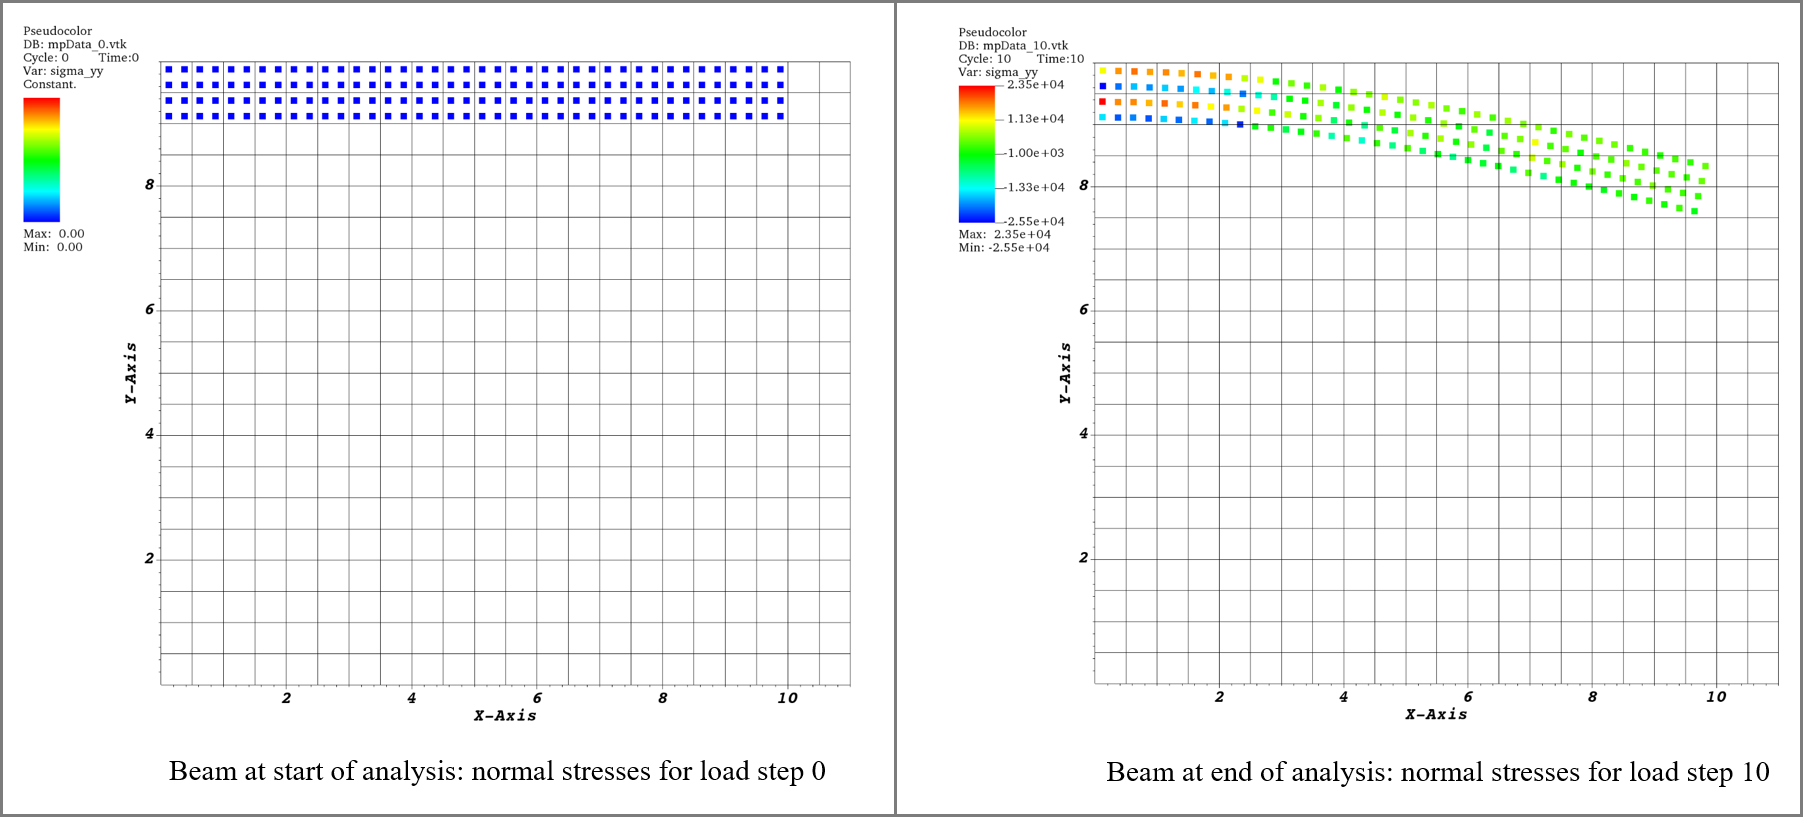

In [17]:
mp_data[0].vp

array([0.06165124])